In [124]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops
from skimage.transform import resize
import os
import nibabel as nib
import cv2

In [118]:
train_image_path = './01-raw/imagesTr'
train_label_path = './01-raw/labelsTr'
test_image_path = './01-raw/imagesTs'
test_labels_path = './01-raw/labelsTs'
train_image_write_path = './Task500_BrainTumor/imagesTr/'
test_image_write_path = './Task500_BrainTumor/imagesTs/'
train_label_write_path = './Task500_BrainTumor/labelsTr/'
test_label_write_path = './Task500_BrainTumor/labelsTs/'
suffix = '.mhd'
width = 240
height = 240
reshaped_width = 128
reshaped_height = 128

train_ids = [int(fpath.split('_')[1].split('.')[0]) for fpath in os.listdir(train_image_path) if fpath.endswith(suffix)]
train_ids.sort()
test_ids = [int(fpath.split('_')[1].split('.')[0]) for fpath in os.listdir(test_image_path) if fpath.endswith(suffix)]
test_ids.sort()

Bounding box: (65, 53, 214, 185)


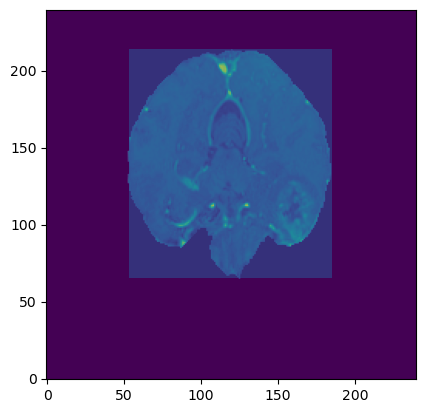

In [71]:
def plot_image_and_box(id):
    image = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(train_image_path, f"mri_{id}.mhd"), sitk.sitkFloat32))
    fig, ax = plt.subplots()
    ax.imshow(image, origin='lower')
    label_image = image.copy()
    label_image[image>0] = 1
    props = regionprops(label_image.astype('int'))
    box = props[0].bbox
    print('Bounding box: '+ str(box))
    ax.add_patch(plt.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], alpha=0.4))
    plt.show()

def get_box(id):
    image = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(train_image_path, f"mri_{id}.mhd"), sitk.sitkFloat32))
    label_image = image.copy()
    label_image[image>0] = 1
    props = regionprops(label_image.astype('int'))
    box = props[0].bbox
    return box

def get_smallest_margin(image_ids):
    boxes = []
    for image_id in image_ids:
        boxes.append(get_box(image_id))
    boxes = np.array(boxes)
    res = np.zeros(4)
    res[0] = np.min(boxes[:, 0])
    res[1] = np.min(boxes[:, 1])
    res[2] = 240-np.max(boxes[:, 2])
    res[3] = 240-np.max(boxes[:, 3])
    res = res.astype('int')
    return np.min(res)

def crop_image(image, margin):
    width = image.shape[1]
    height = image.shape[0]
    return image[margin:height-margin, margin:width-margin]

plot_image_and_box(0)

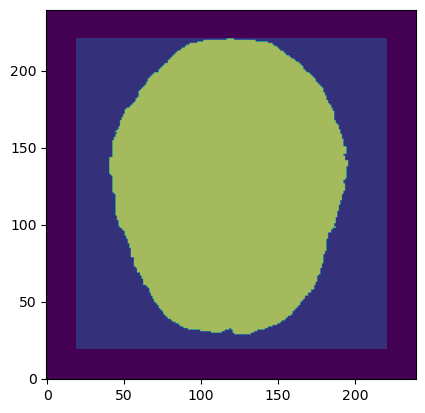

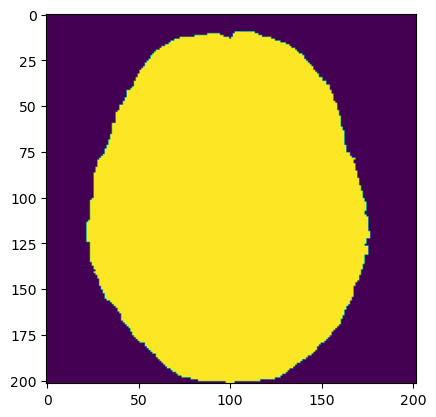

In [72]:
# image = np.zeros((240, 240))
# for tr_id in train_ids:
#     image += sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(train_image_path, f"mri_{tr_id}.mhd"), sitk.sitkFloat32))
# plt.imshow(image)
# np.save('all_images.npy', image)

image = np.load('all_images.npy')
label_image = image.copy()
label_image[label_image>0] = 1
margin = get_smallest_margin(train_ids)
fig, ax = plt.subplots()
ax.imshow(label_image, origin='lower')
ax.add_patch(plt.Rectangle((margin, margin), (width-margin)-margin, (height-margin)-margin, alpha=0.4))
plt.show()

cropped_image = crop_image(label_image, margin)
plt.imshow(cropped_image)

In [139]:
def create_file_name(orig_id, id_len):
    if len(str(orig_id)) < id_len:
        orig_id = '0' * (id_len - len(str(orig_id))) + str(orig_id)
    return  'BRATS_'+str(orig_id)+'_0000.nii.gz'

def normalize_image(image):
    mean = np.mean(image)
    std = np.std(image)
    image = image - mean
    image = image / std
    return image

def create_dataset(affine, train_ids, read_path, write_path, margin, reshaped_width, reshaped_height):
    for tr_id in train_ids:
        image = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(read_path, f"mri_{tr_id}.mhd"), sitk.sitkFloat32))
        image = crop_image(image, margin)
        # image = resize(image, (reshaped_width, reshaped_height))
        image = cv2.resize(image, (reshaped_width, reshaped_height), interpolation=cv2.INTER_NEAREST)
        # change [x, y] to [y, x]
        image = np.transpose(image)
        image = normalize_image(image)
        # add dimention here result shape [y, x, 1]
        out_nifti = nib.Nifti1Image(image[..., None], affine)
        out_name = create_file_name(tr_id, 5)
        nib.save(out_nifti, os.path.join(write_path, out_name))

def create_label_dataset(affine, train_ids, read_path, write_path, margin, reshaped_width, reshaped_height):
    for tr_id in train_ids:
        image = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(read_path, f"seg_{tr_id}.mhd"), sitk.sitkInt8))
        image = crop_image(image, margin)
        image[image==4] = 3
        image = cv2.resize(image, (reshaped_width, reshaped_height), interpolation=cv2.INTER_NEAREST)
        # change [x, y] to [y, x]
        image = np.transpose(image)
        # # add dimention here result shape [y, x, 1]
        out_nifti = nib.Nifti1Image(image[..., None], affine)
        out_name = create_file_name(tr_id, 5)
        nib.save(out_nifti, os.path.join(write_path, out_name))

In [140]:
affine_array = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
create_dataset(affine_array, train_ids, train_image_path, train_image_write_path, margin, reshaped_width, reshaped_height)

In [141]:
affine_array = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
create_dataset(affine_array, test_ids, test_image_path, test_image_write_path, margin, reshaped_width, reshaped_height)

In [142]:
create_label_dataset(affine_array, train_ids, train_label_path, train_label_write_path, margin, reshaped_width, reshaped_height)

In [143]:
create_label_dataset(affine_array, test_ids, test_labels_path, test_label_write_path, margin, reshaped_width, reshaped_height)

In [144]:
print(len(os.listdir('./Task500_BrainTumor/imagesTr/')) * 2 == len(os.listdir('./01-raw/imagesTr/')))
print(len(os.listdir('./Task500_BrainTumor/imagesTs/')) * 2 == len(os.listdir('./01-raw/imagesTs/')))
print(len(os.listdir('./Task500_BrainTumor/labelsTr/')) * 2 == len(os.listdir('./01-raw/labelsTr/')))
print(len(os.listdir('./Task500_BrainTumor/labelsTs/')) * 2 == len(os.listdir('./01-raw/labelsTs/')))

True
True
True
True


In [145]:
# def get_boundary(image):
#     width = image.shape[1]
#     image_width_sum = np.sum(image, axis=0)
#     image_width_sum[image_width_sum > 0] = 1
#     height = image.shape[0]
#     image_height_sum = np.sum(image, axis=1)
#     image_height_sum[image_height_sum>0] = 1
#     for i in range(1, width):
#         if image_width_sum[i] + image_width_sum[i-1] == 1:
#             print(i)
#     for i in range(1, height):
#         if image_height_sum[i] + image_height_sum[i-1] == 1:
#             print(i)
    

# get_boundary()